In [ ]:
import time
import math

def exec_time_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} 실행 시간: {end_time - start_time:.5f}초")
        return result
    return wrapper

def round_angle(angle):
    """
    각도 어림하기 (45도 간격으로 반올림)
    """
    # 기준 각도 (라디안 단위로 변환)
    predefined_angles = [0,
                            math.radians(45),
                            math.radians(90),
                            math.radians(135),
                            math.radians(180),
                            -math.radians(135),
                            -math.radians(90),
                            -math.radians(45)
                        ]

    # 각도를 -π에서 π 사이로 변환
    angle = (angle + math.pi) % (2 * math.pi) - math.pi
    
    # 가장 가까운 각도 찾기
    def adjust_angle(angle):
        # 라디안 기준으로 각도를 -π에서 π 사이로 변환
        if angle > math.pi:
            angle -= 2 * math.pi  # -π에서 π 사이로 변환
        return angle
    closest_angle = min(predefined_angles, key=lambda x: abs(adjust_angle(abs(angle - x))))
    # print(math.degrees(closest_angle))

    return closest_angle

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Literal
import math
from filterpy.monte_carlo import multinomial_resample
from filterpy.monte_carlo import residual_resample
from filterpy.monte_carlo import stratified_resample
from filterpy.monte_carlo import systematic_resample
from dtaidistance import dtw


UnitType = Literal['meter', 'coordinate']

class ParticleFilter:
    def __init__(self, m_map, gaussian_params, num_particles: int, map_constraints: np.ndarray, step_noise=0.2, gyro_noise=0.1, map_noise=0.2, plot=False, unit: UnitType = 'coordinate'):
        """
        Initialize the particle filter.
        :param gaussian_params: Dict with Gaussian parameters {'mean_x', 'mean_y', 'std_x', 'std_y'}
        :param num_particles: Number of particles.
        :param map_constraints: Spatial constraints of the map (e.g., walls, paths).
        :param gyro_noise: Standard deviation of noise added to direction changes.
        :param map_noise: Standard deviation of noise in map matching.
        """
        m_map_df = pd.DataFrame(m_map, columns=['X', 'Y', 'mag'])
        self.m_map = {(row.X, row.Y): row.mag for row in m_map_df.itertuples()}
        self.gaussian_params = gaussian_params  
        self.num_particles = num_particles
        self.map_constraints = map_constraints
        self.gyro_noise = gyro_noise
        self.step_noise = step_noise
        self.map_noise = map_noise
        self.plot = plot
        self.unit = unit
        
        self.particles = self.initialize_particles()


    @exec_time_decorator
    def initialize_particles(self):
        """
        Randomly initialize particles based on map constraints.
        """
        particles = []

        for _ in range(self.num_particles):
            while True:
                # Generate x and y from Gaussian distribution
                x = np.random.normal(self.gaussian_params['mean_x'], self.gaussian_params['std_x'])
                y = np.random.normal(self.gaussian_params['mean_y'], self.gaussian_params['std_y'])
                
                # Check if the generated coordinates are within the map constraints
                if self.map_constraints_check(x, y):
                    # print(f"({x},{y} is in map")
                    break

            # Random direction for the particle
            direction = np.arctan2(x - self.gaussian_params['mean_x'], y - self.gaussian_params['mean_y'])  # Direction in radians
            # direction = math.radians(110)
            particles.append({'x': x, 'y': y, 'direction': direction, 'weight': 1.0})

            # Initialize the particle with weight 1.0
            # particles = pd.concat([particles, new_particle], ignore_index=True)

        return pd.DataFrame(particles, columns=['x', 'y', 'direction', 'weight'])


    @exec_time_decorator
    def move_particles(self, step_length: float, step_radian: float):
        """
        Move particles based on step length and gyro data.
        """
        if self.unit == 'coordinate':
            step_length /= 0.6

        # Update direction with gyro data and noise
        # delta_direction = step_radian + np.random.normal(0, self.gyro_noise)
        # self.particles.loc[:, 'direction'] += delta_direction
        self.particles['direction'] += step_radian + np.random.normal(0, self.gyro_noise, size=len(self.particles)) # 노이즈를 particle마다 다른 값 부여
        
        self.particles['rounded_direction'] = self.particles['direction'].apply(lambda x: round_angle(x))

        # Move particles in updated direction
        # dx = (step_length + self.step_noise * step_length) * np.cos(self.particles.loc[:, 'direction'])
        # dy = (step_length + self.step_noise * step_length) * np.sin(self.particles.loc[:, 'direction'])
        dx = (step_length + self.step_noise * step_length) * np.cos(self.particles.loc[:, 'rounded_direction'])
        dy = (step_length + self.step_noise * step_length) * np.sin(self.particles.loc[:, 'rounded_direction'])
        self.particles.loc[:, 'x'] += dx
        self.particles.loc[:, 'y'] += dy


    # @exec_time_decorator
    # @staticmethod
    def calculate_weights_worker(self, particle, observed_vector: pd.DataFrame, step_length):
        """
        Calculate particle weights using DTW similarity.
        """

        if self.map_constraints_check(particle['x'], particle['y']) is False:
            particle['weight'] *= 0.000000001
            # particle['weight'] *= 0
            print(f"particle has reached the constraints!!!")
            # particle['weight'] *= 0.0001
        else:
            # Simulate predicted vector (from M-Map) at particle's position
            predicted_vector = self.get_m_map_vector_(particle, step_length)  # Replace with map-based vector lookup
            
            if 999.9 in predicted_vector:
                print("999.9 in predicted_vector")
                particle['weight'] *= 0.000000001
                return particle
            
            observed_arr = np.array(observed_vector)
            predicted_arr = np.array(predicted_vector)
            
            # dtaidistance 사용
            distance = dtw.distance_fast(observed_arr - np.mean(observed_arr), predicted_arr - np.mean(predicted_arr))
            
            particle['dtw_distance'] = distance
            particle['weight'] *= np.exp(- distance**2 / (2 * self.map_noise**2))

            # print(f"particle: ({particle['x']}, {particle['y']}), distance:{distance}, weight: {particle['weight']}")
        
        return particle
    
    
    @exec_time_decorator
    def calculate_weights(self, observed_vector: pd.DataFrame, step_length):
        """
        Calculate particle weights
        """
        
        # 병렬 실행 X
        self.particles = pd.DataFrame([ self.calculate_weights_worker(
                    particle,
                    observed_vector,
                    step_length
        ) for _, particle in self.particles.iterrows()])
        
        # 병렬 실행 O
        # futures = [] 
        # with ThreadPoolExecutor() as executor:
        #     for _, particle in self.particles.iterrows():
        #         # 작업을 개별적으로 제출
        #         future = executor.submit(self.calculate_weights_worker,
        #             self,
        #             particle,
        #             observed_vector,
        #             step_length
        #         )
        #         futures.append(future)

        #     # 완료된 작업에서 결과 수집
        #     self.particles = pd.DataFrame([future.result() for future in as_completed(futures)])
        
        self.particles.loc[:, 'weight'] += 1.e-300      # avoid round-off to zero
        self.particles.loc[:, 'weight'] /= sum(self.particles.loc[:, 'weight']) # normalize -> Posterior


    @exec_time_decorator
    def resample_particles(self):   
        """
        Resample particles based on their weights.
        """
        def resample_from_index(particles, indexes):
            # Resample particles using the given indexes
            self.particles[:] = self.particles.iloc[indexes].reset_index(drop=True)
    
            # Update weights to be uniform
            self.particles['weight'] = 1.0 / len(self.particles)
            
        def neff(weights):
            return 1. / np.sum(np.square(weights))

        N = len(self.particles)

        # resample if too few effective particles
        if neff(self.particles.loc[:, 'weight']) < N/2:
            print("resample")
            indexes = multinomial_resample(self.particles.loc[:, 'weight'])
            resample_from_index(self.particles, indexes)
        # assert np.allclose(self.particles.loc[:, 'weight'], 1/N)

    @exec_time_decorator
    def estimate_weighted_position(self):
        """
        Estimate user position based on particle distribution.
        """
        # total_weight = self.particles['weight'].sum()
        # if total_weight == 0:
        #     raise ValueError("The total weight is zero, cannot calculate weighted position.")
        # weighted_x = (self.particles['x'] * self.particles['weight']).sum() / total_weight
        # weighted_y = (self.particles['y'] * self.particles['weight']).sum() / total_weight
        
        # weight 높은 particle 200개만 사용
        count = 200
        top_df = self.particles.sort_values(['weight'], ascending=False)[:count]
        total_weight = top_df['weight'].sum()
        if total_weight == 0:
            raise ValueError("The total weight is zero, cannot calculate weighted position.")
        weighted_x = (top_df['x'] * top_df['weight']).sum() / total_weight
        weighted_y = (top_df['y'] * top_df['weight']).sum() / total_weight
        
        return weighted_x, weighted_y
    
    
    
    @exec_time_decorator
    def estimate_position(self, use_weighted_average=False, first_iter: bool = False):
        """
        Estimate user position based on particle distribution using a hybrid strategy.
        
        Args:
            use_weighted_average (bool): Flag to switch to weighted average strategy.
            
        Returns:
            tuple: (x_mean, y_mean) representing the estimated position.
        """

        if first_iter:
            return self.gaussian_params['mean_x'], self.gaussian_params['mean_y']

        if not use_weighted_average:
            # 초기 단계: 최대 가중치를 가진 입자의 위치 사용
            max_weight_particle = self.particles.loc[self.particles['weight'].idxmax()]
            return max_weight_particle['x'], max_weight_particle['y']
        else:
            # 수렴 이후: 상위 50% 가중치 입자들의 가중 평균 사용
            half_count = len(self.particles) // 2
            top_particles = self.particles.nlargest(half_count, 'weight')  # 상위 50% 선택
            total_weight = top_particles['weight'].sum()
            
            x_mean = (top_particles['x'] * top_particles['weight']).sum() / total_weight
            y_mean = (top_particles['y'] * top_particles['weight']).sum() / total_weight
            
            return x_mean, y_mean


    @exec_time_decorator
    def run_filter(self, observed_vector: pd.DataFrame, step_length, step_radian, first_iter: bool, use_weighted_average: bool):
        """ 
        Run the particle filter over a sequence of observations.
        """
        print(f"# of particle: {len(self.particles)}")
        
        positions = []

        self.move_particles(step_length, step_radian)

        self.calculate_weights(observed_vector, step_length)
        # positions.append(self.estimate_position(use_weighted_average, first_iter))
        positions.append(self.estimate_weighted_position())
        self.resample_particles()
        
        if self.plot:
            sampled_particle = self.particles.sample(frac=0.2, random_state=42)  # 5% 샘플링
            for _, particle in sampled_particle.iterrows():
                # 방향 벡터 (cos, sin)로 계산
                dx = np.cos(particle['direction'])
                dy = np.sin(particle['direction'])
                
                # weight에 따라 화살표 길이를 조정
                scale_factor = max(min(particle['weight'] * 100, 10), 1)  # 최소, 최대 길이 보장
                dx *= scale_factor
                dy *= scale_factor

                # 화살표 그리기
                plt.arrow(
                    particle['x'], particle['y'], dx, dy,
                    head_width=0.1, head_length=0.1, alpha=min(scale_factor, 1),
                    fc='red', ec='red'
                )

        return positions


    # @exec_time_decorator
    def map_constraints_check(self, x: float, y: float) -> bool:
        """
        if the (x,y) impossible return false  
        """
        x_max = self.map_constraints.shape[0] - 0.5
        y_max = self.map_constraints.shape[1] - 0.5

        if (0 <= x < x_max) and (0 <= y < y_max):
            return not self.map_constraints[math.floor(x), math.floor(y)]
        else:
            return False


    # @exec_time_decorator
    def get_m_map_vector_(self, particle, step_length):
        """
        find the points from (x1, y1) to (x2, y2) 
        concat the magnitudes of points
        """
        vector = []

        dx = step_length * np.cos(particle['direction'])
        dy = step_length * np.sin(particle['direction'])

        x1 = particle['x'] - dx
        y1 = particle['y'] - dy
        
        x2 = particle['x']
        y2 = particle['y']

        
        # m_map_df = pd.DataFrame(m_map, columns=['X', 'Y', 'mag'])

        # (x1, y1)에서 (x2, y2)까지 이동하는 단계 수 계산
        # TODO: 걸음 상수 바꾸기
        # num_steps = math.dist((x1,y1),(x2,y2)) / 0.65
        num_steps = 10

        # m_map의 magnitude 값을 읽어서 벡터화
        for i in range(num_steps + 1):
            # 시작점과 끝점 사이를 보간하여 (x, y) 계산
            x = np.round(x1 + (x2 - x1) * i / num_steps, 1)
            y = np.round(y1 + (y2 - y1) * i / num_steps, 1)
            
            x = float(x) if isinstance(x, np.ndarray) else x
            y = float(y) if isinstance(y, np.ndarray) else y

            magnitude = self.m_map.get((x,y), 999.9)

            vector.append(magnitude)

        return vector




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\sage\SynologyDrive\dev\magicol\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\sage\SynologyDrive\dev\magicol\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\sage\SynologyDrive\dev\magicol\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self

In [4]:
import math

map_constraints = np.loadtxt('./data/obstacle_mask.txt', dtype=bool)
m_map = pd.read_csv("./data/M_map_version2.csv")

# Constraint Ploting
# print(f"M-Map Origianl Data Shape: {map_constraints.shape}")
# plt.imshow(map_constraints.T, cmap='gray', origin='lower')
# plt.title("Map Constraints (Binary Data)")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.margins(0,0)
# plt.show()

# M-MAP Ploting
# print(f"M-Map Origianl Data Shape: {m_map.shape}")
# sampled_map = m_map.sample(frac=0.1, random_state=42)  # 10% 샘플링
# obstacle_sampled_map = sampled_map[sampled_map['mag'] == 999.9]
# sampled_map = sampled_map[sampled_map['mag'] != 999.9]

# scatter = plt.scatter(sampled_map['X'], sampled_map['Y'], c=sampled_map['mag'], s=1, vmin=100, vmax=300)
# plt.scatter(obstacle_sampled_map['X'], obstacle_sampled_map['Y'], color='red', s=1)
# plt.colorbar(scatter, label="Value")
# plt.title("M Map (10% Sampling)")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.margins(0,0)
# plt.show()

# initial state
gaussian_params1 = {"mean_x": 92, "mean_y": 47, "std_x": 0.1, "std_y": 0.1}
gaussian_params2 = {"mean_x": 114, "mean_y": 25, "std_x": 0.1, "std_y": 0.1}
gaussian_params3 = {"mean_x": 33, "mean_y": 28, "std_x": 0.1, "std_y": 0.1}
gaussian_params4 = {"mean_x": 49, "mean_y": 52, "std_x": 0.1, "std_y": 0.1}
gaussian_params99 = {"mean_x": 7, "mean_y": 52, "std_x": 0.1, "std_y": 0.1}

# Initialize particle filter
pf = ParticleFilter(
    num_particles=1000,
    gaussian_params=gaussian_params2,
    m_map=m_map,
    map_constraints=map_constraints,
    gyro_noise=math.radians(0.01),
    step_noise=0.02,
    map_noise=0.7,
    plot = True,
    unit='coordinate'
)

initialize_particles 실행 시간: 0.00600초


assert that len(step_length): 34 = len(step_orientation_radians): 34
# of particle: 1000
move_particles 실행 시간: 0.00952초
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!


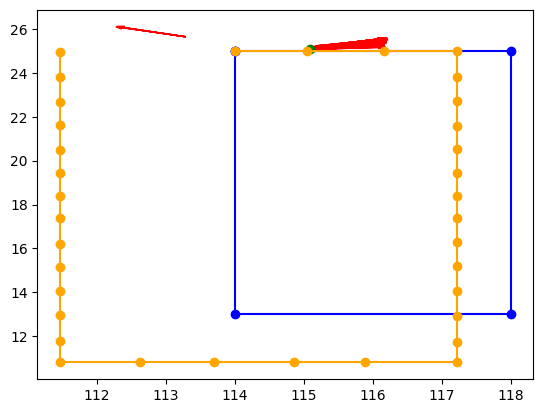

# of particle: 1000
move_particles 실행 시간: 0.01073초
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
calculate_weights 실행 시간: 0.64155초
estimate_weighted_position 실행 시간: 0.00099초
resample
resample_particles 실행 시간: 0.00262초
run_filter 실행 시간: 0.90371초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814))]


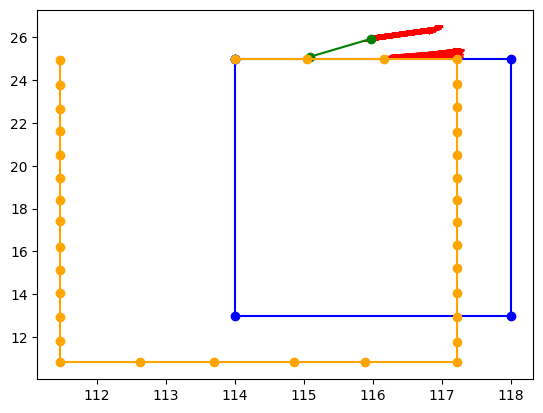

# of particle: 1000
move_particles 실행 시간: 0.00575초
calculate_weights 실행 시간: 0.51718초
estimate_weighted_position 실행 시간: 0.00099초
resample_particles 실행 시간: 0.00128초
run_filter 실행 시간: 0.73777초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814)), (np.float64(117.00227606189098), np.float64(25.91223412921668))]


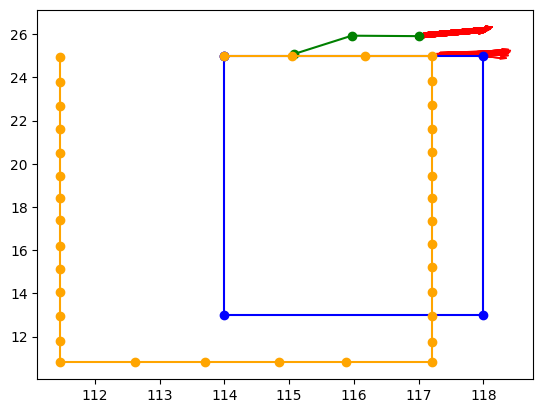

# of particle: 1000
move_particles 실행 시간: 0.00852초
calculate_weights 실행 시간: 0.46768초
estimate_weighted_position 실행 시간: 0.00210초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.70306초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814)), (np.float64(117.00227606189098), np.float64(25.91223412921668)), (np.float64(117.04239474135795), np.float64(24.721347714244327))]


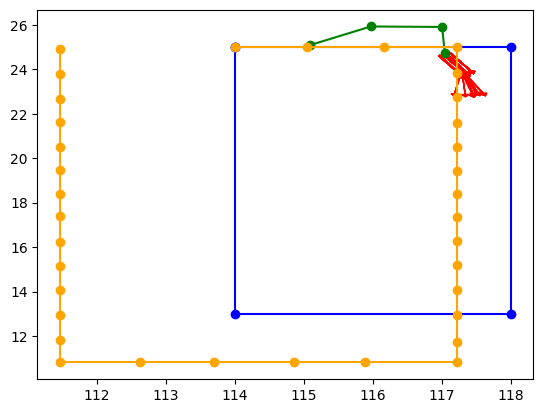

# of particle: 1000
move_particles 실행 시간: 0.00755초
calculate_weights 실행 시간: 0.44559초
estimate_weighted_position 실행 시간: 0.00300초
resample
resample_particles 실행 시간: 0.00254초
run_filter 실행 시간: 0.79317초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814)), (np.float64(117.00227606189098), np.float64(25.91223412921668)), (np.float64(117.04239474135795), np.float64(24.721347714244327)), (np.float64(117.34620584888533), np.float64(22.849505310713923))]


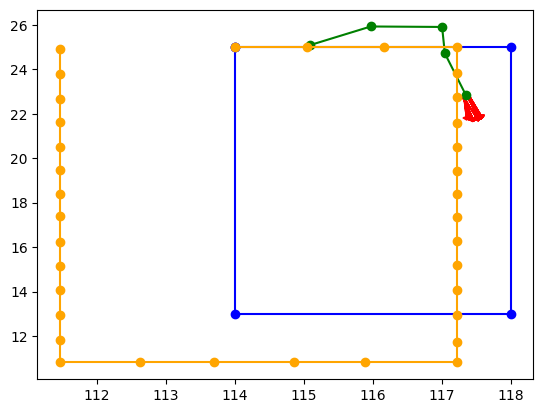

# of particle: 1000
move_particles 실행 시간: 0.00651초
calculate_weights 실행 시간: 0.42316초
estimate_weighted_position 실행 시간: 0.00213초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.63117초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814)), (np.float64(117.00227606189098), np.float64(25.91223412921668)), (np.float64(117.04239474135795), np.float64(24.721347714244327)), (np.float64(117.34620584888533), np.float64(22.849505310713923)), (np.float64(117.34746355326023), np.float64(21.684275126207552))]


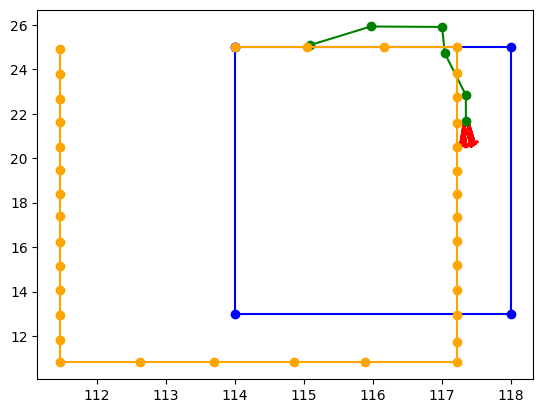

# of particle: 1000
move_particles 실행 시간: 0.00975초
calculate_weights 실행 시간: 0.42584초
estimate_weighted_position 실행 시간: 0.00061초
resample
resample_particles 실행 시간: 0.00311초
run_filter 실행 시간: 0.67299초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814)), (np.float64(117.00227606189098), np.float64(25.91223412921668)), (np.float64(117.04239474135795), np.float64(24.721347714244327)), (np.float64(117.34620584888533), np.float64(22.849505310713923)), (np.float64(117.34746355326023), np.float64(21.684275126207552)), (np.float64(117.37643799789188), np.float64(20.6574319918161))]


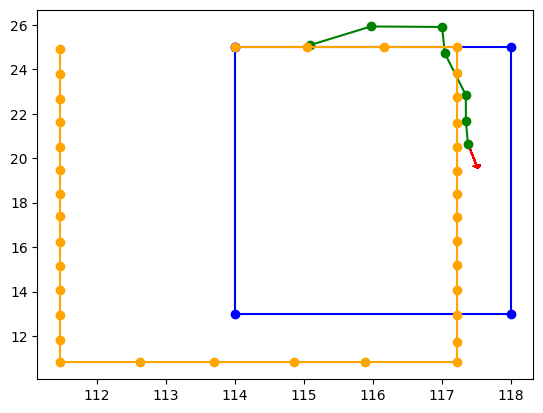

# of particle: 1000
move_particles 실행 시간: 0.00735초
calculate_weights 실행 시간: 0.43466초
estimate_weighted_position 실행 시간: 0.00095초
resample_particles 실행 시간: 0.00111초
run_filter 실행 시간: 0.79349초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814)), (np.float64(117.00227606189098), np.float64(25.91223412921668)), (np.float64(117.04239474135795), np.float64(24.721347714244327)), (np.float64(117.34620584888533), np.float64(22.849505310713923)), (np.float64(117.34746355326023), np.float64(21.684275126207552)), (np.float64(117.37643799789188), np.float64(20.6574319918161)), (np.float64(117.37643807948155), np.float64(19.539943163480423))]


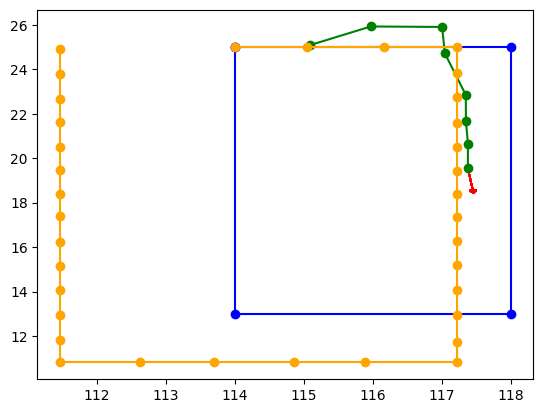

# of particle: 1000
move_particles 실행 시간: 0.00915초
calculate_weights 실행 시간: 0.58273초
estimate_weighted_position 실행 시간: 0.00000초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.75757초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814)), (np.float64(117.00227606189098), np.float64(25.91223412921668)), (np.float64(117.04239474135795), np.float64(24.721347714244327)), (np.float64(117.34620584888533), np.float64(22.849505310713923)), (np.float64(117.34746355326023), np.float64(21.684275126207552)), (np.float64(117.37643799789188), np.float64(20.6574319918161)), (np.float64(117.37643807948155), np.float64(19.539943163480423)), (np.float64(117.37643807948156), np.float64(18.494060379298723))]


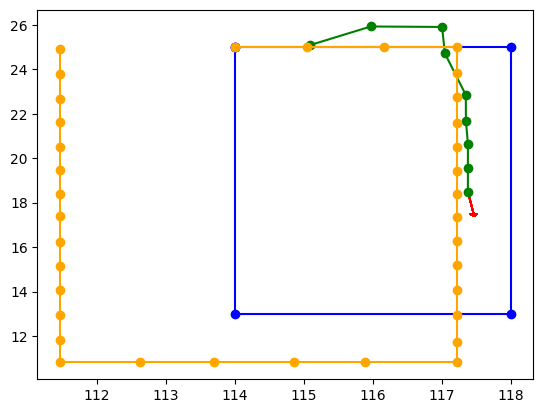

# of particle: 1000
move_particles 실행 시간: 0.00754초
calculate_weights 실행 시간: 0.57234초
estimate_weighted_position 실행 시간: 0.00152초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.78465초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814)), (np.float64(117.00227606189098), np.float64(25.91223412921668)), (np.float64(117.04239474135795), np.float64(24.721347714244327)), (np.float64(117.34620584888533), np.float64(22.849505310713923)), (np.float64(117.34746355326023), np.float64(21.684275126207552)), (np.float64(117.37643799789188), np.float64(20.6574319918161)), (np.float64(117.37643807948155), np.float64(19.539943163480423)), (np.float64(117.37643807948156), np.float64(18.494060379298723)), (np.float64(117.3764380794816), np.float64(17.445203050206324))]


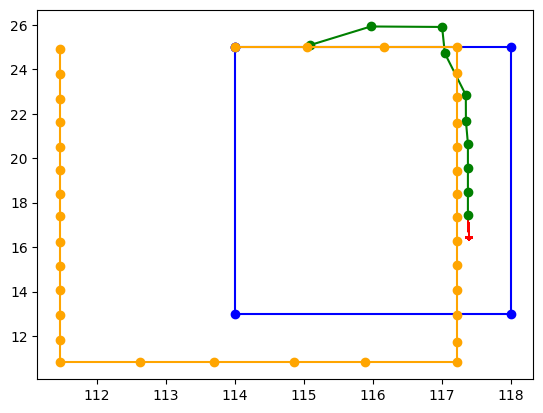

# of particle: 1000
move_particles 실행 시간: 0.00855초
calculate_weights 실행 시간: 0.44003초
estimate_weighted_position 실행 시간: 0.00200초
resample_particles 실행 시간: 0.00062초
run_filter 실행 시간: 0.75174초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814)), (np.float64(117.00227606189098), np.float64(25.91223412921668)), (np.float64(117.04239474135795), np.float64(24.721347714244327)), (np.float64(117.34620584888533), np.float64(22.849505310713923)), (np.float64(117.34746355326023), np.float64(21.684275126207552)), (np.float64(117.37643799789188), np.float64(20.6574319918161)), (np.float64(117.37643807948155), np.float64(19.539943163480423)), (np.float64(117.37643807948156), np.float64(18.494060379298723)), (np.float64(117.3764380794816), np.float64(17.445203050206324)), (np.float64(117.3764380794815), np.float64(16.33939890507966))]


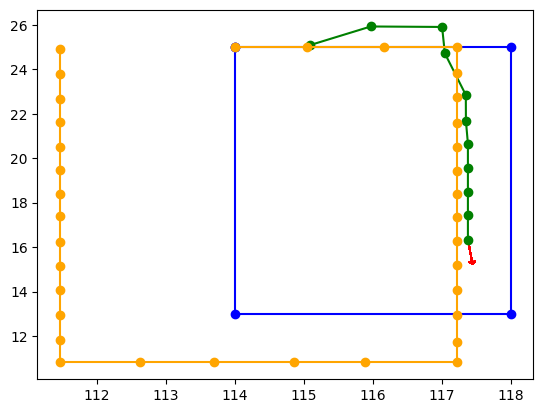

# of particle: 1000
move_particles 실행 시간: 0.01065초
calculate_weights 실행 시간: 0.37947초
estimate_weighted_position 실행 시간: 0.00100초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.59779초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814)), (np.float64(117.00227606189098), np.float64(25.91223412921668)), (np.float64(117.04239474135795), np.float64(24.721347714244327)), (np.float64(117.34620584888533), np.float64(22.849505310713923)), (np.float64(117.34746355326023), np.float64(21.684275126207552)), (np.float64(117.37643799789188), np.float64(20.6574319918161)), (np.float64(117.37643807948155), np.float64(19.539943163480423)), (np.float64(117.37643807948156), np.float64(18.494060379298723)), (np.float64(117.3764380794816), np.float64(17.445203050206324)), (np.float64(117.3764380794815), np.float64(16.33939890507966)), (np.float64(117.3764380794816), np.float64(15.240724237231376))]


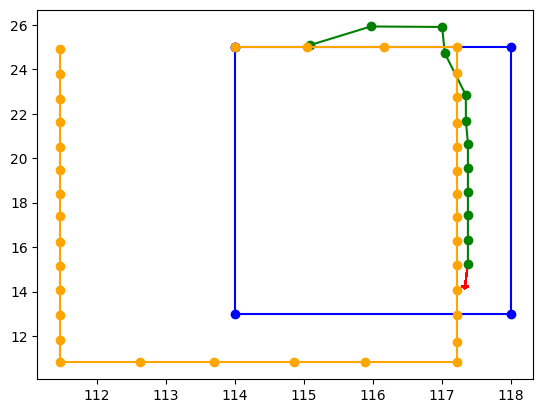

# of particle: 1000
move_particles 실행 시간: 0.00561초
calculate_weights 실행 시간: 0.39995초
estimate_weighted_position 실행 시간: 0.00105초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.60350초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814)), (np.float64(117.00227606189098), np.float64(25.91223412921668)), (np.float64(117.04239474135795), np.float64(24.721347714244327)), (np.float64(117.34620584888533), np.float64(22.849505310713923)), (np.float64(117.34746355326023), np.float64(21.684275126207552)), (np.float64(117.37643799789188), np.float64(20.6574319918161)), (np.float64(117.37643807948155), np.float64(19.539943163480423)), (np.float64(117.37643807948156), np.float64(18.494060379298723)), (np.float64(117.3764380794816), np.float64(17.445203050206324)), (np.float64(117.3764380794815), np.float64(16.33939890507966)), (np.float64(117.3764380794816), np.float64(15.240724237231376)), (np.float64(117.37643807948

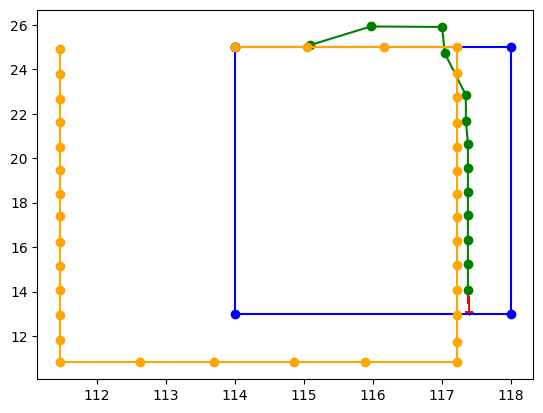

# of particle: 1000
move_particles 실행 시간: 0.00775초
calculate_weights 실행 시간: 0.35786초
estimate_weighted_position 실행 시간: 0.00195초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.63624초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814)), (np.float64(117.00227606189098), np.float64(25.91223412921668)), (np.float64(117.04239474135795), np.float64(24.721347714244327)), (np.float64(117.34620584888533), np.float64(22.849505310713923)), (np.float64(117.34746355326023), np.float64(21.684275126207552)), (np.float64(117.37643799789188), np.float64(20.6574319918161)), (np.float64(117.37643807948155), np.float64(19.539943163480423)), (np.float64(117.37643807948156), np.float64(18.494060379298723)), (np.float64(117.3764380794816), np.float64(17.445203050206324)), (np.float64(117.3764380794815), np.float64(16.33939890507966)), (np.float64(117.3764380794816), np.float64(15.240724237231376)), (np.float64(117.37643807948

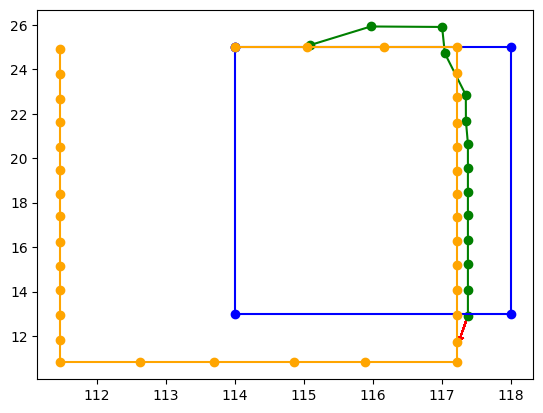

# of particle: 1000
move_particles 실행 시간: 0.00871초
calculate_weights 실행 시간: 0.36146초
estimate_weighted_position 실행 시간: 0.00100초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.55661초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814)), (np.float64(117.00227606189098), np.float64(25.91223412921668)), (np.float64(117.04239474135795), np.float64(24.721347714244327)), (np.float64(117.34620584888533), np.float64(22.849505310713923)), (np.float64(117.34746355326023), np.float64(21.684275126207552)), (np.float64(117.37643799789188), np.float64(20.6574319918161)), (np.float64(117.37643807948155), np.float64(19.539943163480423)), (np.float64(117.37643807948156), np.float64(18.494060379298723)), (np.float64(117.3764380794816), np.float64(17.445203050206324)), (np.float64(117.3764380794815), np.float64(16.33939890507966)), (np.float64(117.3764380794816), np.float64(15.240724237231376)), (np.float64(117.37643807948

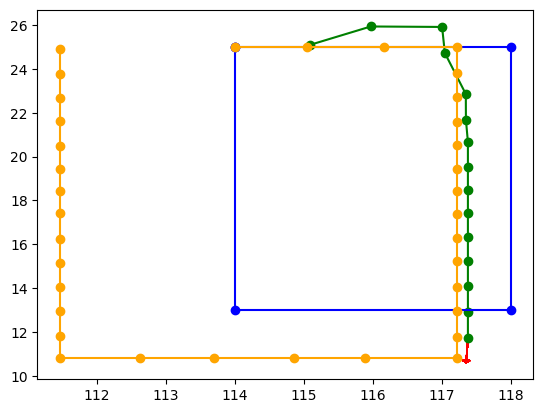

# of particle: 1000
move_particles 실행 시간: 0.00651초
calculate_weights 실행 시간: 0.38551초
estimate_weighted_position 실행 시간: 0.00000초
resample_particles 실행 시간: 0.00111초
run_filter 실행 시간: 0.59086초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814)), (np.float64(117.00227606189098), np.float64(25.91223412921668)), (np.float64(117.04239474135795), np.float64(24.721347714244327)), (np.float64(117.34620584888533), np.float64(22.849505310713923)), (np.float64(117.34746355326023), np.float64(21.684275126207552)), (np.float64(117.37643799789188), np.float64(20.6574319918161)), (np.float64(117.37643807948155), np.float64(19.539943163480423)), (np.float64(117.37643807948156), np.float64(18.494060379298723)), (np.float64(117.3764380794816), np.float64(17.445203050206324)), (np.float64(117.3764380794815), np.float64(16.33939890507966)), (np.float64(117.3764380794816), np.float64(15.240724237231376)), (np.float64(117.37643807948

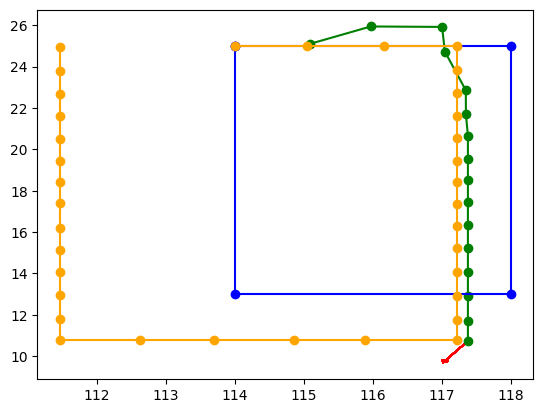

# of particle: 1000
move_particles 실행 시간: 0.00872초
calculate_weights 실행 시간: 0.41570초
estimate_weighted_position 실행 시간: 0.00160초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.58555초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814)), (np.float64(117.00227606189098), np.float64(25.91223412921668)), (np.float64(117.04239474135795), np.float64(24.721347714244327)), (np.float64(117.34620584888533), np.float64(22.849505310713923)), (np.float64(117.34746355326023), np.float64(21.684275126207552)), (np.float64(117.37643799789188), np.float64(20.6574319918161)), (np.float64(117.37643807948155), np.float64(19.539943163480423)), (np.float64(117.37643807948156), np.float64(18.494060379298723)), (np.float64(117.3764380794816), np.float64(17.445203050206324)), (np.float64(117.3764380794815), np.float64(16.33939890507966)), (np.float64(117.3764380794816), np.float64(15.240724237231376)), (np.float64(117.37643807948

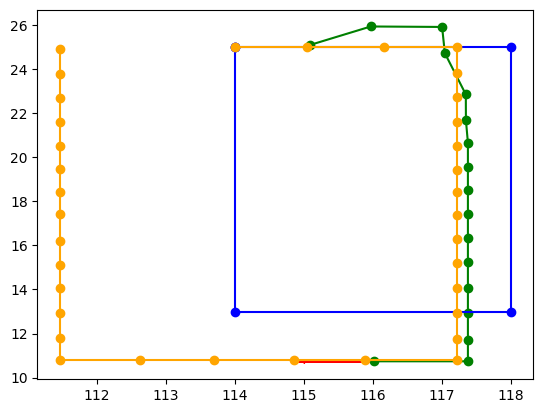

# of particle: 1000
move_particles 실행 시간: 0.00677초
calculate_weights 실행 시간: 0.35508초
estimate_weighted_position 실행 시간: 0.00061초
resample_particles 실행 시간: 0.00111초
run_filter 실행 시간: 0.53337초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814)), (np.float64(117.00227606189098), np.float64(25.91223412921668)), (np.float64(117.04239474135795), np.float64(24.721347714244327)), (np.float64(117.34620584888533), np.float64(22.849505310713923)), (np.float64(117.34746355326023), np.float64(21.684275126207552)), (np.float64(117.37643799789188), np.float64(20.6574319918161)), (np.float64(117.37643807948155), np.float64(19.539943163480423)), (np.float64(117.37643807948156), np.float64(18.494060379298723)), (np.float64(117.3764380794816), np.float64(17.445203050206324)), (np.float64(117.3764380794815), np.float64(16.33939890507966)), (np.float64(117.3764380794816), np.float64(15.240724237231376)), (np.float64(117.37643807948

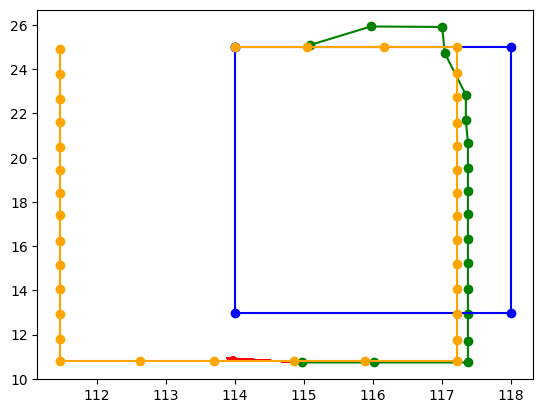

# of particle: 1000
move_particles 실행 시간: 0.00672초
calculate_weights 실행 시간: 0.40920초
estimate_weighted_position 실행 시간: 0.00098초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.57356초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814)), (np.float64(117.00227606189098), np.float64(25.91223412921668)), (np.float64(117.04239474135795), np.float64(24.721347714244327)), (np.float64(117.34620584888533), np.float64(22.849505310713923)), (np.float64(117.34746355326023), np.float64(21.684275126207552)), (np.float64(117.37643799789188), np.float64(20.6574319918161)), (np.float64(117.37643807948155), np.float64(19.539943163480423)), (np.float64(117.37643807948156), np.float64(18.494060379298723)), (np.float64(117.3764380794816), np.float64(17.445203050206324)), (np.float64(117.3764380794815), np.float64(16.33939890507966)), (np.float64(117.3764380794816), np.float64(15.240724237231376)), (np.float64(117.37643807948

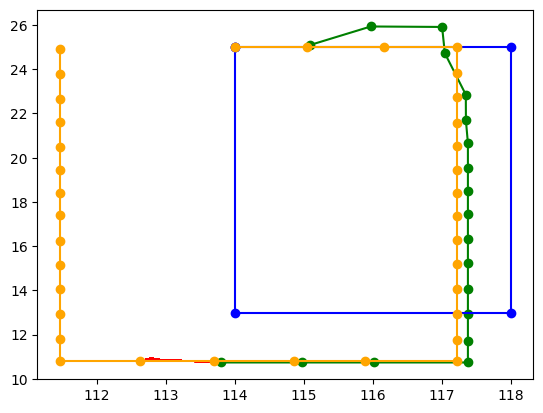

# of particle: 1000
move_particles 실행 시간: 0.00648초
calculate_weights 실행 시간: 0.35245초
estimate_weighted_position 실행 시간: 0.00101초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.54964초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814)), (np.float64(117.00227606189098), np.float64(25.91223412921668)), (np.float64(117.04239474135795), np.float64(24.721347714244327)), (np.float64(117.34620584888533), np.float64(22.849505310713923)), (np.float64(117.34746355326023), np.float64(21.684275126207552)), (np.float64(117.37643799789188), np.float64(20.6574319918161)), (np.float64(117.37643807948155), np.float64(19.539943163480423)), (np.float64(117.37643807948156), np.float64(18.494060379298723)), (np.float64(117.3764380794816), np.float64(17.445203050206324)), (np.float64(117.3764380794815), np.float64(16.33939890507966)), (np.float64(117.3764380794816), np.float64(15.240724237231376)), (np.float64(117.37643807948

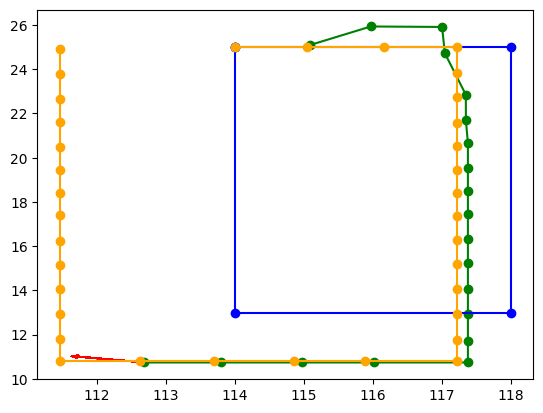

# of particle: 1000
move_particles 실행 시간: 0.00875초
calculate_weights 실행 시간: 0.51149초
estimate_weighted_position 실행 시간: 0.00099초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.67790초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814)), (np.float64(117.00227606189098), np.float64(25.91223412921668)), (np.float64(117.04239474135795), np.float64(24.721347714244327)), (np.float64(117.34620584888533), np.float64(22.849505310713923)), (np.float64(117.34746355326023), np.float64(21.684275126207552)), (np.float64(117.37643799789188), np.float64(20.6574319918161)), (np.float64(117.37643807948155), np.float64(19.539943163480423)), (np.float64(117.37643807948156), np.float64(18.494060379298723)), (np.float64(117.3764380794816), np.float64(17.445203050206324)), (np.float64(117.3764380794815), np.float64(16.33939890507966)), (np.float64(117.3764380794816), np.float64(15.240724237231376)), (np.float64(117.37643807948

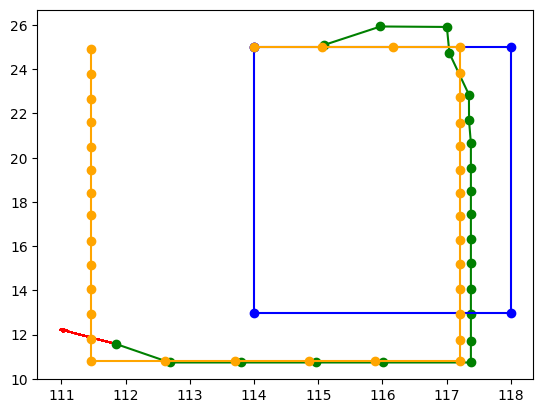

# of particle: 1000
move_particles 실행 시간: 0.00677초
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the cons

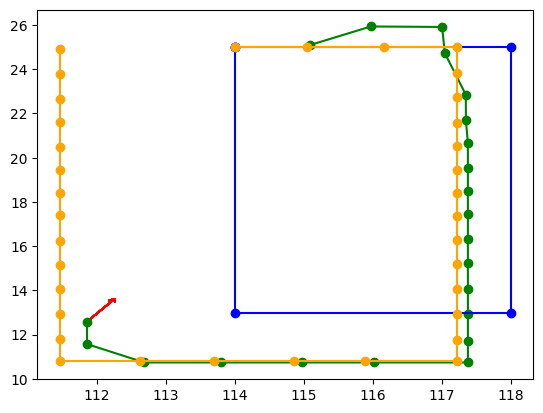

# of particle: 1000
move_particles 실행 시간: 0.00599초
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the cons

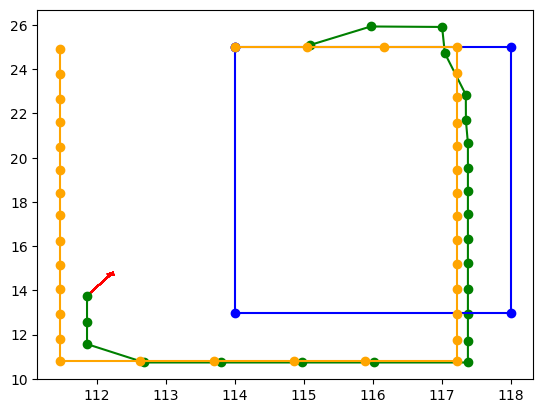

# of particle: 1000
move_particles 실행 시간: 0.00673초
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the cons

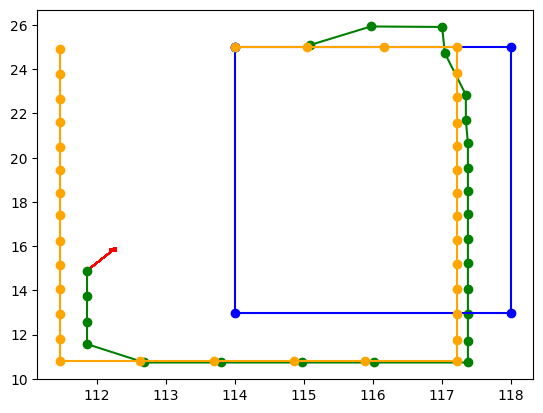

# of particle: 1000
move_particles 실행 시간: 0.00836초
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the cons

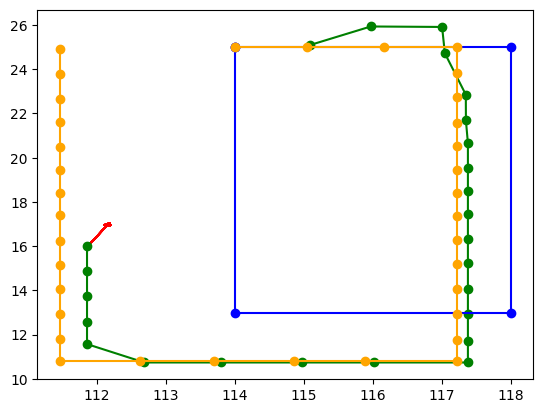

# of particle: 1000
move_particles 실행 시간: 0.00751초
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the cons

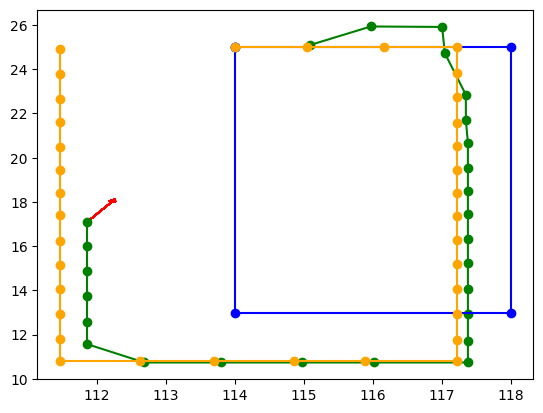

# of particle: 1000
move_particles 실행 시간: 0.00674초
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the cons

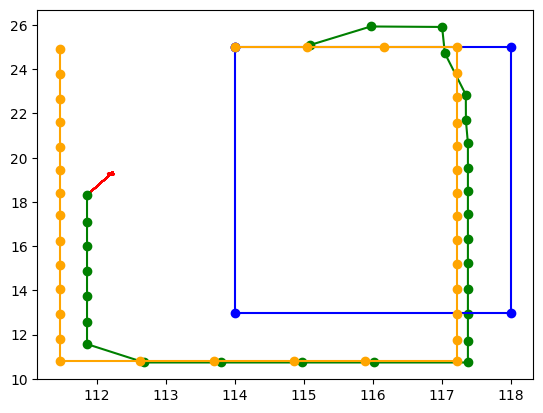

# of particle: 1000
move_particles 실행 시간: 0.00512초
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the cons

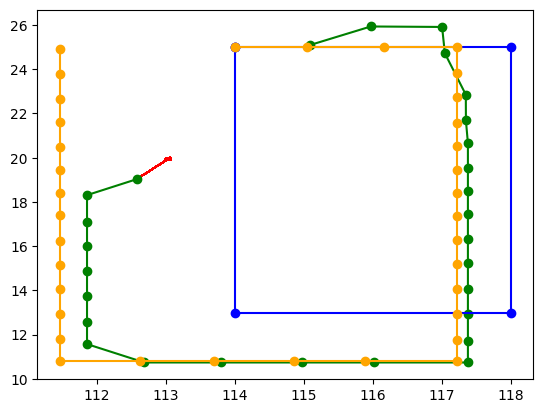

# of particle: 1000
move_particles 실행 시간: 0.00771초
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the constraints!!!
particle has reached the cons

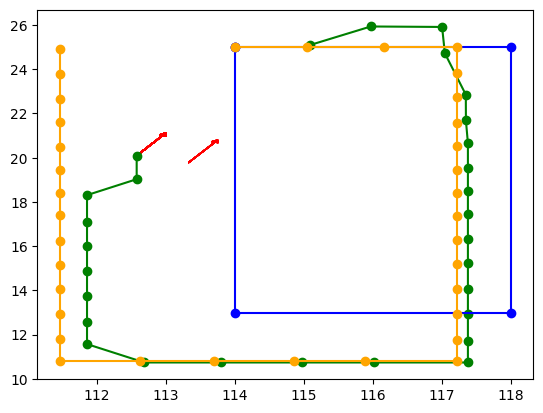

# of particle: 1000
move_particles 실행 시간: 0.00874초
calculate_weights 실행 시간: 0.50254초
estimate_weighted_position 실행 시간: 0.00000초
resample_particles 실행 시간: 0.00162초
run_filter 실행 시간: 0.68775초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814)), (np.float64(117.00227606189098), np.float64(25.91223412921668)), (np.float64(117.04239474135795), np.float64(24.721347714244327)), (np.float64(117.34620584888533), np.float64(22.849505310713923)), (np.float64(117.34746355326023), np.float64(21.684275126207552)), (np.float64(117.37643799789188), np.float64(20.6574319918161)), (np.float64(117.37643807948155), np.float64(19.539943163480423)), (np.float64(117.37643807948156), np.float64(18.494060379298723)), (np.float64(117.3764380794816), np.float64(17.445203050206324)), (np.float64(117.3764380794815), np.float64(16.33939890507966)), (np.float64(117.3764380794816), np.float64(15.240724237231376)), (np.float64(117.37643807948

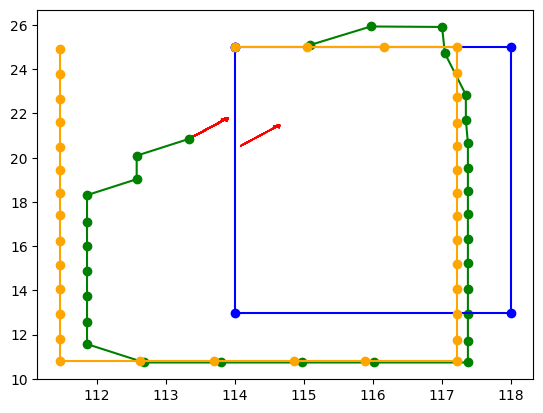

# of particle: 1000
move_particles 실행 시간: 0.00653초
calculate_weights 실행 시간: 0.38106초
estimate_weighted_position 실행 시간: 0.00100초
resample_particles 실행 시간: 0.00099초
run_filter 실행 시간: 0.56743초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814)), (np.float64(117.00227606189098), np.float64(25.91223412921668)), (np.float64(117.04239474135795), np.float64(24.721347714244327)), (np.float64(117.34620584888533), np.float64(22.849505310713923)), (np.float64(117.34746355326023), np.float64(21.684275126207552)), (np.float64(117.37643799789188), np.float64(20.6574319918161)), (np.float64(117.37643807948155), np.float64(19.539943163480423)), (np.float64(117.37643807948156), np.float64(18.494060379298723)), (np.float64(117.3764380794816), np.float64(17.445203050206324)), (np.float64(117.3764380794815), np.float64(16.33939890507966)), (np.float64(117.3764380794816), np.float64(15.240724237231376)), (np.float64(117.37643807948

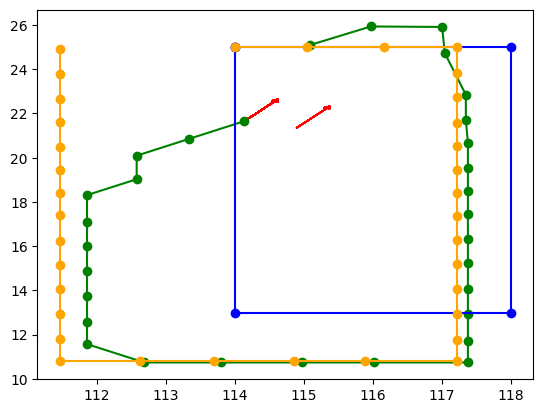

# of particle: 1000
move_particles 실행 시간: 0.00762초
calculate_weights 실행 시간: 0.42554초
estimate_weighted_position 실행 시간: 0.00200초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.62323초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814)), (np.float64(117.00227606189098), np.float64(25.91223412921668)), (np.float64(117.04239474135795), np.float64(24.721347714244327)), (np.float64(117.34620584888533), np.float64(22.849505310713923)), (np.float64(117.34746355326023), np.float64(21.684275126207552)), (np.float64(117.37643799789188), np.float64(20.6574319918161)), (np.float64(117.37643807948155), np.float64(19.539943163480423)), (np.float64(117.37643807948156), np.float64(18.494060379298723)), (np.float64(117.3764380794816), np.float64(17.445203050206324)), (np.float64(117.3764380794815), np.float64(16.33939890507966)), (np.float64(117.3764380794816), np.float64(15.240724237231376)), (np.float64(117.37643807948

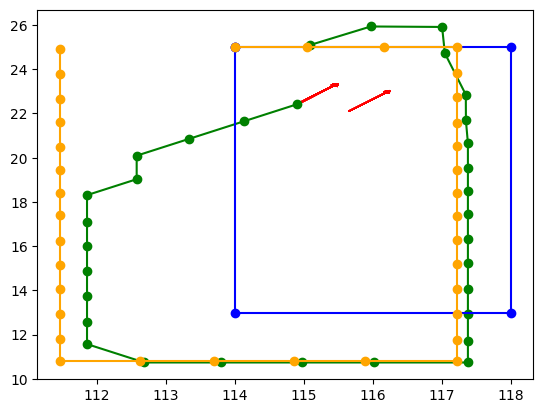

# of particle: 1000
move_particles 실행 시간: 0.00773초
calculate_weights 실행 시간: 0.52275초
estimate_weighted_position 실행 시간: 0.00100초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.76008초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814)), (np.float64(117.00227606189098), np.float64(25.91223412921668)), (np.float64(117.04239474135795), np.float64(24.721347714244327)), (np.float64(117.34620584888533), np.float64(22.849505310713923)), (np.float64(117.34746355326023), np.float64(21.684275126207552)), (np.float64(117.37643799789188), np.float64(20.6574319918161)), (np.float64(117.37643807948155), np.float64(19.539943163480423)), (np.float64(117.37643807948156), np.float64(18.494060379298723)), (np.float64(117.3764380794816), np.float64(17.445203050206324)), (np.float64(117.3764380794815), np.float64(16.33939890507966)), (np.float64(117.3764380794816), np.float64(15.240724237231376)), (np.float64(117.37643807948

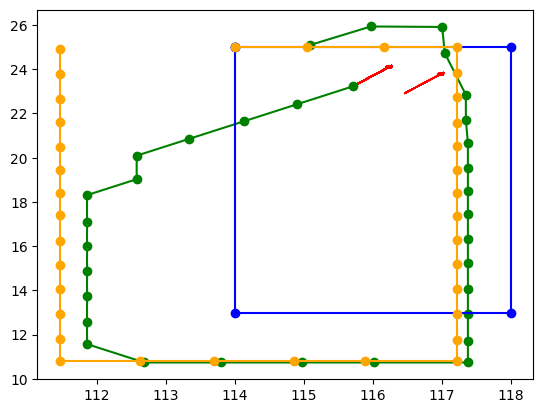

# of particle: 1000
move_particles 실행 시간: 0.00769초
calculate_weights 실행 시간: 0.35733초
estimate_weighted_position 실행 시간: 0.00100초
resample_particles 실행 시간: 0.00099초
run_filter 실행 시간: 0.52756초
[(np.float64(115.0832397536086), np.float64(25.09076462518445)), (np.float64(115.96868632438945), np.float64(25.93368796917814)), (np.float64(117.00227606189098), np.float64(25.91223412921668)), (np.float64(117.04239474135795), np.float64(24.721347714244327)), (np.float64(117.34620584888533), np.float64(22.849505310713923)), (np.float64(117.34746355326023), np.float64(21.684275126207552)), (np.float64(117.37643799789188), np.float64(20.6574319918161)), (np.float64(117.37643807948155), np.float64(19.539943163480423)), (np.float64(117.37643807948156), np.float64(18.494060379298723)), (np.float64(117.3764380794816), np.float64(17.445203050206324)), (np.float64(117.3764380794815), np.float64(16.33939890507966)), (np.float64(117.3764380794816), np.float64(15.240724237231376)), (np.float64(117.37643807948

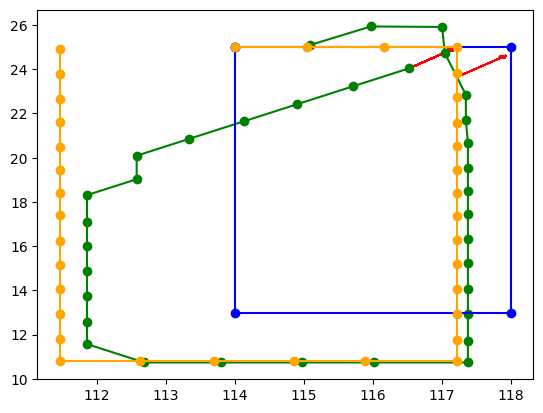

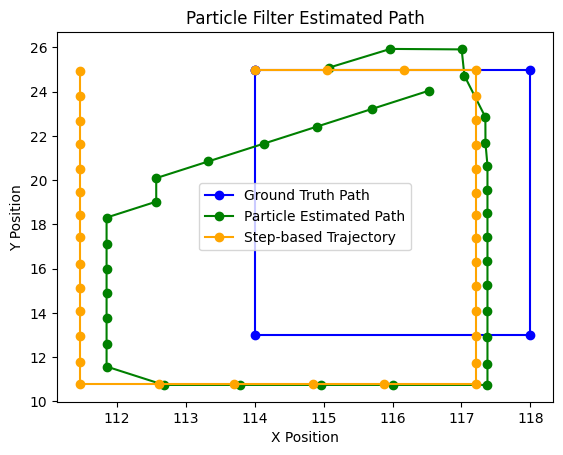

In [5]:

from step_length import *
from step_orientation import *

path_name = 'Path2'

acc_df = pd.read_csv(f"./data/{path_name}_freeOri_A31_12_06/Accelerometer.csv")
gyro_df = pd.read_csv(f"./data/{path_name}_freeOri_A31_12_06/GyroscopeUncalibrated.csv")
ori_df = pd.read_csv(f"./data/{path_name}_freeOri_A31_12_06/Orientation.csv")
mag_df = pd.read_csv(f"./data/{path_name}_freeOri_A31_12_06/MagnetometerUncalibrated.csv")
mag_df['mag'] = mag_df.apply(lambda x: math.sqrt(x['x']*x['x'] + x['y']*x['y'] + x['z']*x['z']), axis=1 )
del mag_df['x']
del mag_df['y']
del mag_df['z']

path_dict = {}
path_dict['Path1'] = pd.DataFrame([(92, 47), (102, 47), (102, 40), (92,40), (92,47)], columns=['x', 'y'])
path_dict['Path2'] = pd.DataFrame([(114, 25), (118, 25), (118, 13), (114,13), (114, 25)], columns=['x', 'y'])
path_dict['Path3'] = pd.DataFrame([(33, 28), (38, 28), (44, 22)], columns=['x', 'y'])
path_dict['Path4'] = pd.DataFrame([(49, 52), (58, 52), (58, 65), (63, 65), (63, 52), (69, 52)], columns=['x', 'y'])

step_lengths = compute_step_timestamp(
    acceleration_threshold=0.001,
    weinberg_gain=0.5,
    acce=acc_df.drop(columns=['seconds_elapsed', 'time']).to_numpy(),
    frequency=100.0
)
step_orientation_radians: list[float] = []
current_angles: list[float] = []

# Plot Ground Truth Path
ground_truth_path = path_dict[path_name]

# Tranjectory
x, y = ground_truth_path.iloc[0]  # 초기 위치
trajectory_x = [x]
trajectory_y = [y]
trajectory_x_ori = [x]
trajectory_y_ori = [y]
current_angle = math.radians(0)  # 초기 방향 (radians)

for step in step_lengths:
    step_length = step['step_length']
    start = step['start']
    end = step['end']

    # Turning estimation
    estimated_radian = estimate_turning_angle(
        gyro_data=gyro_df.iloc[start:end, :],
        frequency=100.0
    )
    step_orientation_radians.append(estimated_radian)

    # 방향 업데이트
    current_angle += estimated_radian 
    
    current_angles.append(current_angle) 
    current_angle = round_angle(current_angle)
    
    step_length /= 0.6
    # 새로운 위치 계산
    dx = step_length * math.cos(current_angle)
    dy = step_length * math.sin(current_angle)
    x += dx
    y += dy
    trajectory_x.append(x)
    trajectory_y.append(y)
    
    dx = step_length * math.cos(round_angle(ori_df['yaw'].iloc[end]))
    dy = step_length * math.sin(round_angle(ori_df['yaw'].iloc[end]))
    trajectory_x_ori.append(trajectory_x_ori[-1] + dx)
    trajectory_y_ori.append(trajectory_y_ori[-1] + dy)
    

print(f"assert that len(step_length): {len(step_lengths)} = len(step_orientation_radians): {len(step_orientation_radians)}")

estimated_positions = []

for idx, (step_length, step_orientation_radian) in enumerate(zip(step_lengths, step_orientation_radians)):
    length = step_length['step_length']
    start = step_length['start']
    end = step_length['end']
    
    use_weighted_average = True
    if 0 <= idx < 5:
        use_weighted_average = False

    result = pf.run_filter(mag_df.iloc[start:end], length, step_orientation_radian, False, use_weighted_average)
    estimated_positions += result
    
    print(estimated_positions)
    # NumPy 배열로 변환
    positions_array = np.array(estimated_positions)
    
    # import cv2
    # floor_plan_path = 'floor_plan/KakaoTalk_20241124_152724186_02.png'  # 평면도 이미지 파일 경로
    # floor_plan = cv2.imread(floor_plan_path)
    # floor_plan = cv2.cvtColor(floor_plan, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 포맷이므로 RGB로 변환
    # plt.imshow(floor_plan, extent=(0, 153, 0, 65), origin='upper') # extent=(x_min, x_max, y_min, y_max)


    # 첫 번째 점
    if idx == 0:
        plt.plot(positions_array[0, 0], positions_array[0, 1], marker='o', color='green', label="Particle Estimated Path")
    else:
        # 이전까지의 경로
        plt.plot(positions_array[:idx+1, 0], positions_array[:idx+1, 1], marker='o', color='green', label="Particle Estimated Path")

    plt.plot(ground_truth_path['x'], ground_truth_path['y'], marker='o', color='blue', label='Ground Truth Path')
    plt.plot(trajectory_x, trajectory_y, marker='o', color='orange', label="Step-based Trajectory")
    # plt.plot(trajectory_x_ori, trajectory_y_ori, marker='o', color='Grey', label="Orientation sensor Step-based Trajectory")
    plt.show()

#Plot results
estimated_positions = np.array(estimated_positions)
estimated_positions = np.squeeze(estimated_positions)  # (n, 2)로 변환

plt.plot(ground_truth_path['x'], ground_truth_path['y'], marker='o', color='blue', label='Ground Truth Path')
plt.plot(estimated_positions[:, 0], estimated_positions[:, 1], marker='o', color='green', label="Particle Estimated Path")
plt.plot(trajectory_x, trajectory_y, marker='o', color='orange', label="Step-based Trajectory")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.title("Particle Filter Estimated Path")
plt.show()
